# Init

In [1]:
import datasets
from datasets import load_dataset, Sequence, Image, DatasetDict, concatenate_datasets, Dataset
import os
import json
from tqdm import tqdm
import re
import copy
import pandas as pd
import numpy as np
from typing import Union, List
import ast
import linecache
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

/home/yuxiang/anaconda3/envs/arrg_preprocessing/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Ontology

In [2]:
class OntologyNode:
    def __init__(self, row_idx, class_id, class_name, df_row):
        self.row_idx = row_idx
        self.class_id = class_id
        self.class_name = class_name
        self.synonyms = [] if df_row["Synonyms"] == "" else df_row["Synonyms"].split("|")
        self.df_row = df_row

        # The tree structure is maintained by the parent and children attributes. Only one level of parent-child relationship is maintained.
        self.parent = []
        self.children = []
        self.is_root = False
        self.tree_level = None

        # It's parents from all levels
        self._all_parents = []

    def add_child(self, child):
        self.children.append(child)

    def add_parent(self, parent):
        self.parent.append(parent)

    @property
    def all_parents(self):
        if self.is_root:
            return []
        elif self._all_parents:
            return self._all_parents
        else:
            for parent in self.parent:
                # 避免父节点重复
                self._all_parents = set(parent.all_parents + [parent])
                self._all_parents = list(self._all_parents)
            return self._all_parents

    def __eq__(self, other):
        if isinstance(other, OntologyNode):
            return self.class_id == other.class_id
        else:
            return self.class_id == other

    def __hash__(self):
        return hash(self.class_id)

    def __str__(self):
        return f"{self.class_id}: {self.class_name}"

    def __repr__(self):
        return self.__str__()


def set_tree_level(curr_node, tree_level):
    curr_node.tree_level = tree_level
    for child in curr_node.children:
        set_tree_level(child, tree_level + 1)
    if not curr_node.children:
        return

In [3]:
def build_radlex_tree(df_csv):
    # Build a RadLex node list
    node_list = []
    root_node = None
    for idx, row in tqdm(df_csv.iterrows(), total=df_csv.shape[0], desc="Building RadLex tree"):
        ontology_node = OntologyNode(row_idx=idx, class_id=row["Class ID"], class_name=row["Preferred Label"], df_row=row)
        if row["Preferred Label"] in row["Class ID"]:
            ontology_node.class_name = row["http://radlex.org/RID/Preferred_Name_for_Obsolete"]
        node_list.append(ontology_node)

    # Resolve the node list and build a RadLex tree
    for node in tqdm(node_list, total=len(node_list), desc="Building RadLex tree"):
        df_row = node.df_row
        parent_ids = df_row["Parents"].split("|")
        for parent_id in parent_ids:
            parent_row_indices = df_csv.loc[df_csv["Class ID"] == parent_id].index
            if not parent_row_indices.empty:
                parent_row_idx = parent_row_indices[0]
                parent_node = node_list[parent_row_idx]
                assert parent_node.class_id == parent_id
                node.add_parent(parent_node)
                parent_node.add_child(node)
            else:
                # In radlex, http://radlex.org/RID/RID0 has parent http://www.w3.org/2002/07/owl#Thing.
                # However, the RID0 is already the root node in the RadLex ontology. We can safely ignore the owl#Thing.
                root_node = node
                node.is_root = True
                node.tree_level = 0

    return node_list, root_node

In [4]:
radlex_csv_path = "/home/yuxiang/liao/resources/bioportal/radlex/RADLEX.csv"
df_radlex_csv = pd.read_csv(radlex_csv_path, keep_default_na=False)
radlex_nodes, radlex_root_node = build_radlex_tree(df_radlex_csv)
radlex_nodes_dict = {node.class_id: node for node in radlex_nodes}
print(f"Number of RadLex nodes: {len(radlex_nodes)}")

# Tracing all parents of nodes
for node in radlex_nodes:
    node.all_parents

set_tree_level(radlex_root_node, tree_level=0)

Building RadLex tree: 100%|██████████| 46761/46761 [01:16<00:00, 607.71it/s]


Number of RadLex nodes: 46761


In [ ]:
print(radlex_nodes[0])
print(radlex_nodes[0].parent)
print(radlex_nodes[0]._all_parents)

http://radlex.org/RID/RID35591: string-of-pearls sign of bowel
[http://radlex.org/RID/RID29023: imaging sign]
[http://radlex.org/RID/RID29023: imaging sign, http://radlex.org/RID/RID0: RadLex ontology entity, http://radlex.org/RID/RID1: RadLex entity, http://radlex.org/RID/RID5: imaging observation]


# Analyse

## Visualize by node level

In [15]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
    "http://radlex.org/RID/RID34861": "object",
    "http://radlex.org/RID/RID1559": "procedure",
    "http://radlex.org/RID/RID3": "anatomical entity",
    "http://radlex.org/RID/RID6": "RadLex descriptor",
    "http://radlex.org/RID/RID34785": "clinical finding",
    "http://radlex.org/RID/RID35977": "property",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):

        # 子节点的统计值会向上传播给父节点
        involved_nodes = node.all_parents + [node]
        for inv_node in involved_nodes:
            node_dockey_dict[inv_node].update(values)

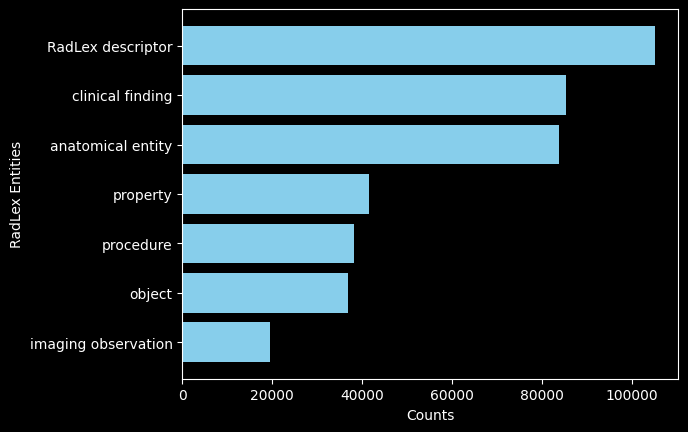

RadLex descriptor: 105052
clinical finding: 85237
anatomical entity: 83691
property: 41465
procedure: 38201
object: 36868
imaging observation: 19455


In [16]:
labels, counts = draw_bar_chart(node_dockey_dict, level=2)
list_nodes(labels, counts)

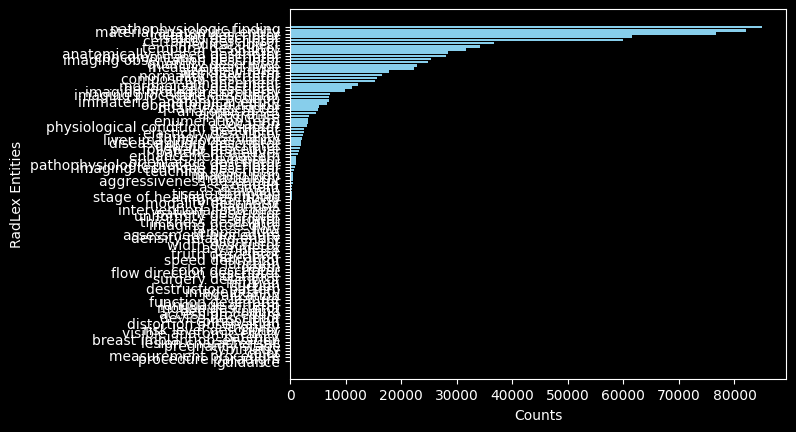

pathophysiologic finding: 85034
material anatomical entity: 82161
location descriptor: 76650
status descriptor: 61476
certainty descriptor: 59889
medical object: 36709
temporal descriptor: 34165
opacity: 31647
anatomically-related descriptor: 28513
concommitance descriptor: 28066
imaging observation descriptor: 25347
quantity descriptor: 24749
measurement type: 22924
size descriptor: 22305
workflow term: 17817
normality descriptor: 16485
composition descriptor: 15622
enhancement: 15299
morphologic descriptor: 12164
generalized descriptor: 11197
imaging procedure property: 9978
imaging procedure descriptor: 7163
patient position: 6957
immaterial anatomical entity: 6942
object manipulation: 6656
quality descriptor: 5296
anatomical set: 5002
appearance: 4737
structure: 3489
enumeration term: 3217
location: 3164
physiological condition descriptor: 2993
treatment: 2477
elasticity descriptor: 2470
tumor vascularity: 2386
liver imaging observation: 2203
disease origin descriptor: 2060
density

In [17]:
labels, counts = draw_bar_chart(node_dockey_dict, level=3)
list_nodes(labels, counts)

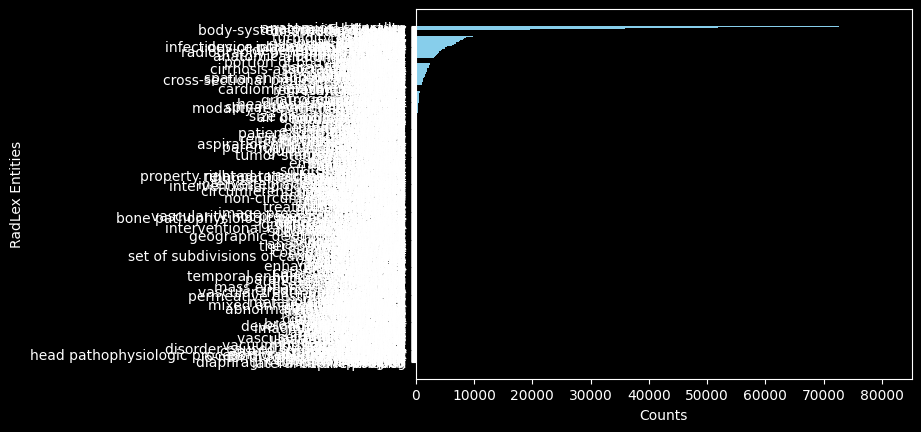

anatomical structure: 81060
laterality: 72563
mechanical disorder: 70335
no: 51900
medical device: 36631
body-system-specific disorder: 35828
with: 20434
distribution pattern: 19582
stable: 19238
unchanged: 18002
small: 17204
normal: 16048
mild: 14270
PtChanged: 13844
volume: 13832
lower: 12949
persistent: 11508
upper: 11472
present: 10875
low: 10156
turbidity descriptor: 9751
limited: 9636
without: 8601
central: 8446
interstitial: 8202
previous: 8193
infiltrate: 8114
increased: 7935
visibility descriptor: 7653
lesion: 7576
diameter: 7362
single: 7023
growth disorder: 6914
increasing: 6908
possibly: 6823
endotracheal: 6494
orderable technique: 6475
lateral: 6391
device placement procedure: 6288
infectious or inflammatory disease: 5551
nasogastric: 5332
patient: 5259
moderate: 5071
acute: 5027
degenerative disorder: 4963
superior: 4895
upright position: 4440
apical: 4427
radiography procedure attribute: 4283
after: 4054
new: 4017
reticular: 3964
imaging view: 3952
distal: 3892
improved:

In [18]:
labels, counts = draw_bar_chart(node_dockey_dict, level=4)
list_nodes(labels, counts)

## Visualize by parent node type

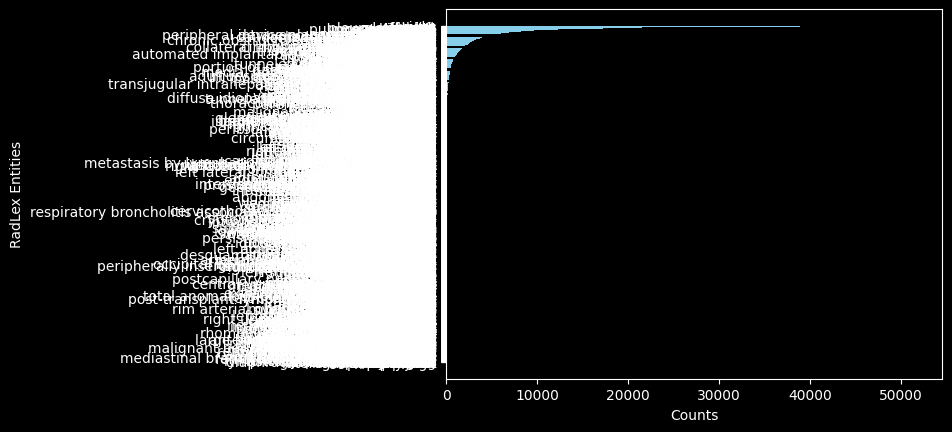

no: 51900
right: 46365
left: 45418
effusion: 42278
pleural effusion: 38865
lung: 32648
opacity: 31357
thorax: 26444
edema: 23750
consolidation: 23721
pneumothorax: 23380
atelectasis: 21568
with: 20434
tube: 20264
bilateral: 20126
pulmonary edema: 19608
stable: 19238
unchanged: 18002
small: 17204
normal: 16048
lining: 15755
mild: 14270
PtChanged: 13844
volume: 13832
lower: 12949
catheter: 12305
persistent: 11508
upper: 11472
present: 10875
lobe: 10478
low: 10156
clear: 9750
limited: 9636
base: 9187
lungs: 9145
focal: 8996
without: 8601
central: 8446
interstitial: 8202
previous: 8193
infiltrate: 8114
increased: 7935
breast mass: 7576
diameter: 7362
single: 7023
parenchyma: 6977
increasing: 6908
possibly: 6823
endotracheal: 6494
endotracheal tube: 6443
nasogastric tube: 6411
lateral: 6391
portable: 6252
right lung: 6067
left lung: 6064
pneumonia: 5770
peripheral intravenous central catheter: 5520
device placement procedure: 5492
nasogastric: 5332
heart: 5282
patient: 5259
diffuse: 5079
mo

In [19]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
    "http://radlex.org/RID/RID34861": "object",
    "http://radlex.org/RID/RID1559": "procedure",
    "http://radlex.org/RID/RID3": "anatomical entity",
    "http://radlex.org/RID/RID6": "RadLex descriptor",
    "http://radlex.org/RID/RID34785": "clinical finding",
    "http://radlex.org/RID/RID35977": "property",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict)
list_nodes(labels, counts)

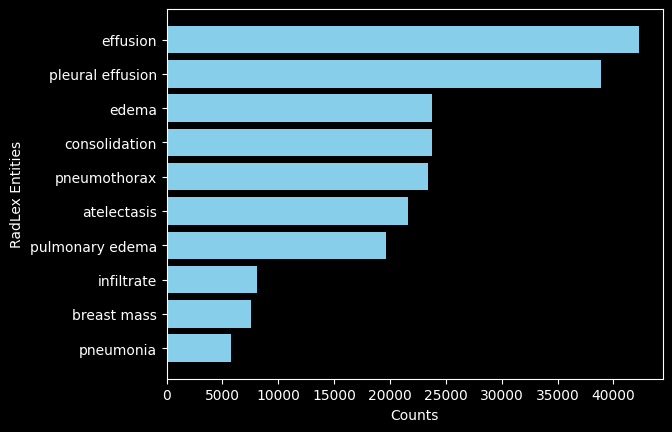

effusion: 42278
pleural effusion: 38865
edema: 23750
consolidation: 23721
pneumothorax: 23380
atelectasis: 21568
pulmonary edema: 19608
infiltrate: 8114
breast mass: 7576
pneumonia: 5770


In [20]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
    "http://radlex.org/RID/RID34785": "clinical finding",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict, threshold=5000)
list_nodes(labels, counts)

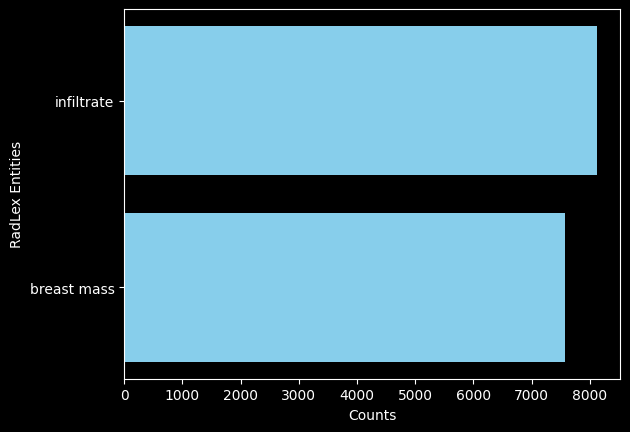

infiltrate: 8114
breast mass: 7576


In [21]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict, threshold=5000)
list_nodes(labels, counts)

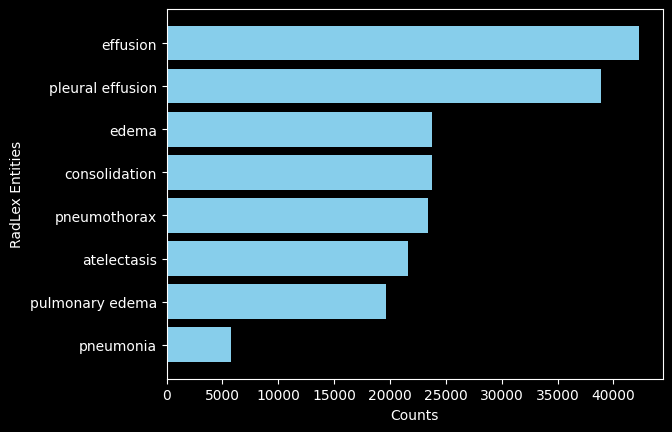

effusion: 42278
pleural effusion: 38865
edema: 23750
consolidation: 23721
pneumothorax: 23380
atelectasis: 21568
pulmonary edema: 19608
pneumonia: 5770


In [22]:
inclusive = {
    "http://radlex.org/RID/RID34785": "clinical finding",
}

node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict, threshold=5000)
list_nodes(labels, counts)

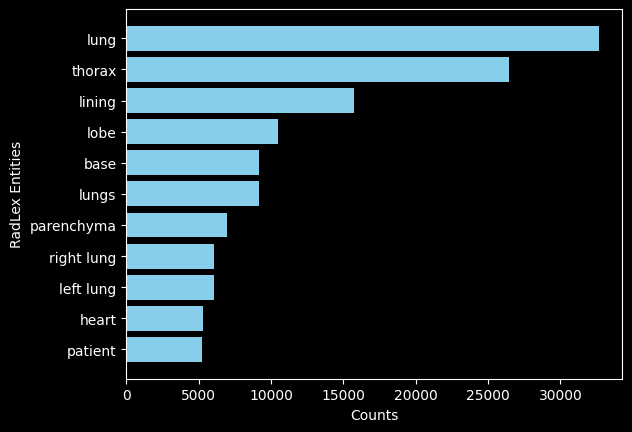

lung: 32648
thorax: 26444
lining: 15755
lobe: 10478
base: 9187
lungs: 9145
parenchyma: 6977
right lung: 6067
left lung: 6064
heart: 5282
patient: 5259


In [23]:
inclusive = {
    "http://radlex.org/RID/RID3": "anatomical entity",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict, threshold=5000)
list_nodes(labels, counts)

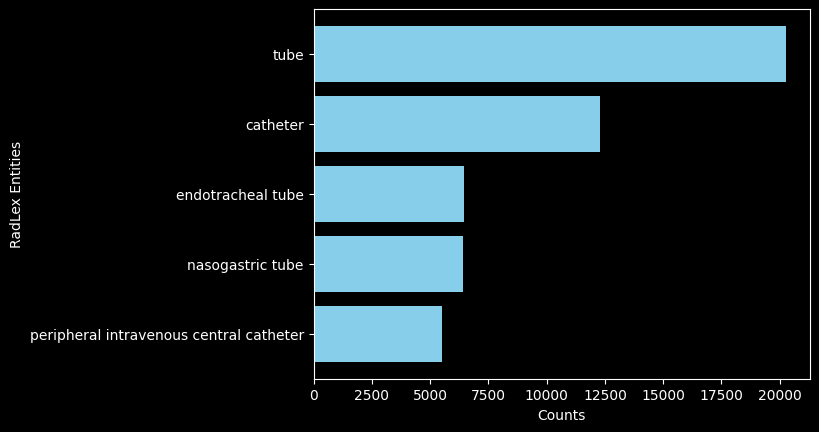

tube: 20264
catheter: 12305
endotracheal tube: 6443
nasogastric tube: 6411
peripheral intravenous central catheter: 5520


In [24]:
inclusive = {
    "http://radlex.org/RID/RID34861": "object",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict, threshold=5000)
list_nodes(labels, counts)

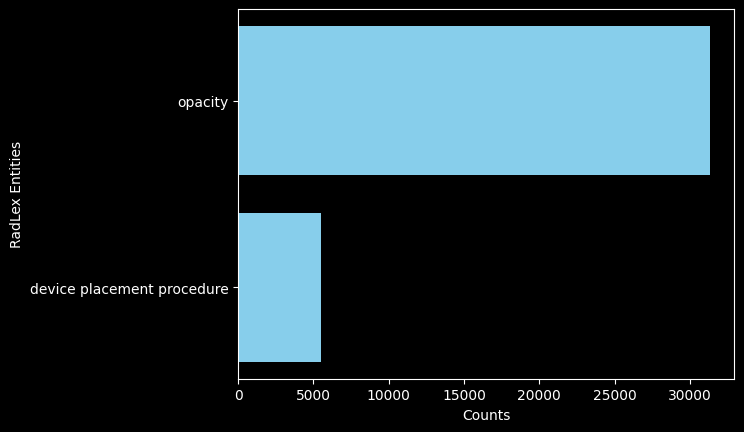

opacity: 31357
device placement procedure: 5492


In [25]:
inclusive = {
    "http://radlex.org/RID/RID1559": "procedure",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict, threshold=5000)
list_nodes(labels, counts)

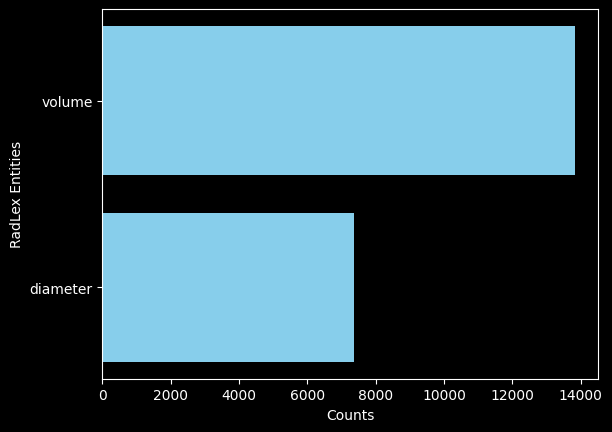

volume: 13832
diameter: 7362


In [26]:
inclusive = {
    "http://radlex.org/RID/RID35977": "property",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict, threshold=5000)
list_nodes(labels, counts)

## Statistic

train, dev, test

In [27]:
# 句子数量
num_reports = len(ds)
print(f"Number of reports in the dataset {num_reports:,}")

Number of reports in the dataset 1,136,366


In [28]:
num_empty_reports = 0
for data_row in tqdm(ds.select_columns("sents")):
    if not data_row["sents"]:
        num_empty_reports += 1

print(f"Number of empty reports: {num_empty_reports:,}")
num_not_empty_reports = num_reports - num_empty_reports
print(f"Number of not empty reports: {num_not_empty_reports:,}")

100%|██████████| 1136366/1136366 [00:11<00:00, 98867.66it/s]

Number of empty reports: 401,730
Number of not empty reports: 734,636


In [29]:
num_sents = 0
num_split_sents = 0
for data_row in tqdm(ds.select_columns(["sents", "split_sents"])):
    if data_row["sents"]:
        num_sents += len(data_row["sents"])
        assert data_row["split_sents"]
        num_split_sents += len(data_row["split_sents"])

print(f"Number of sentences: {num_sents:,}")
print(f"Number of split sentences: {num_split_sents:,}")

100%|██████████| 1136366/1136366 [00:20<00:00, 55883.21it/s]

Number of sentences: 2,872,770
Number of split sentences: 5,330,592


In [30]:
print(f"Average number of sentences per report: {num_sents / num_not_empty_reports:.2f}")
print(f"Average number of split sentences per report: {num_split_sents / num_not_empty_reports:.2f}")

Average number of sentences per report: 3.91
Average number of split sentences per report: 7.26


In [31]:
num_split_sents_with_radlex = 0
for data_row in tqdm(ds.select_columns(["radlex"])):
    for sent_radlex in data_row["radlex"]:
        if sent_radlex:
            num_split_sents_with_radlex += 1

print(f"Number of split sentences with RadLex entities: {num_split_sents_with_radlex:,}")
print(f"% of split sentences with RadLex entities: {num_split_sents_with_radlex/num_split_sents:.2%}")

100%|██████████| 1136366/1136366 [02:27<00:00, 7730.36it/s]

Number of split sentences with RadLex entities: 4,659,470
% of split sentences with RadLex entities: 87.41%


In [32]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
    "http://radlex.org/RID/RID34861": "object",
    "http://radlex.org/RID/RID1559": "procedure",
    "http://radlex.org/RID/RID3": "anatomical entity",
    "http://radlex.org/RID/RID6": "RadLex descriptor",
    "http://radlex.org/RID/RID34785": "clinical finding",
    "http://radlex.org/RID/RID35977": "property",
}

num_not_empty_reports_with_valid_radlex = 0
for data_row in tqdm(ds.select_columns(["split_sents", "radlex"])):
    if data_row["split_sents"]:
        for sent_radlex in data_row["radlex"]:
            is_sent_has_valid_radlex = False
            for radlex_item in sent_radlex:
                node = radlex_nodes_dict[radlex_item["radlex_id"]]
                if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
                    is_sent_has_valid_radlex = True

            if is_sent_has_valid_radlex:
                num_not_empty_reports_with_valid_radlex += 1
                break

print(f"Number of not empty reports with RadLex entities: {num_not_empty_reports_with_valid_radlex:,}")
print(f"% of not empty reports with RadLex entities: {num_not_empty_reports_with_valid_radlex/num_not_empty_reports:.2%}")

100%|██████████| 1136366/1136366 [02:49<00:00, 6686.44it/s]

Number of not empty reports with RadLex entities: 733,093
% of not empty reports with RadLex entities: 99.79%


## 合并数据

  0%|          | 0/2485 [00:00<?, ?it/s]

100%|██████████| 237/237 [00:00<00:00, 329155.65it/s]


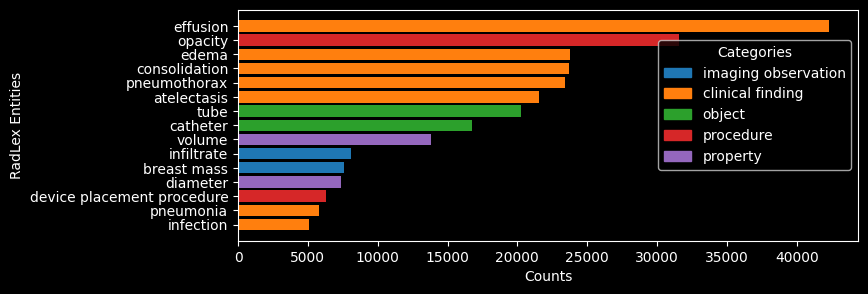

effusion: 42278
opacity: 31577
edema: 23750
consolidation: 23721
pneumothorax: 23380
atelectasis: 21568
tube: 20264
catheter: 16765
volume: 13832
infiltrate: 8114
breast mass: 7576
diameter: 7362
device placement procedure: 6288
pneumonia: 5770
infection: 5110


In [34]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
    "http://radlex.org/RID/RID34785": "clinical finding",
    "http://radlex.org/RID/RID34861": "object",
    "http://radlex.org/RID/RID1559": "procedure",
    "http://radlex.org/RID/RID35977": "property",
    # "http://radlex.org/RID/RID3": "anatomical entity",
    # "http://radlex.org/RID/RID6": "RadLex descriptor",
}
colour_map = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]


node_dockey_dict = defaultdict(set)
for node, values in tqdm(radlex_dockey_dict.items()):
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)


nodes = [node for node in node_dockey_dict.keys()]
dockey_sets = [set(ids) for ids in node_dockey_dict.values()]

# 按照node在报告中出现的次数排序
# 如果node的父节点已经出现过，那么就不再单独统计，而是将其涉及的doc_keys传递给父节点，并跳过当前node
aggregrated_nodes, aggregrated_dockey_sets = [], []
for node, key_set in tqdm(sorted(zip(nodes, dockey_sets), key=lambda x: len(x[1]), reverse=True)):

    is_parent_exist = False
    for parent_node in node.all_parents:
        if parent_node in aggregrated_nodes:
            idx = aggregrated_nodes.index(parent_node)
            aggregrated_dockey_sets[idx].update(key_set)
            is_parent_exist = True
            break

    if not is_parent_exist:
        aggregrated_nodes.append(node)
        aggregrated_dockey_sets.append(key_set)


labels, counts, colours = [], [], []
for node, key_set in tqdm(sorted(zip(aggregrated_nodes, aggregrated_dockey_sets), key=lambda x: len(x[1]), reverse=True)):
    labels.append(node.class_name)
    counts.append(len(key_set))
    for category_idx, category_node_id in enumerate(inclusive.keys()):
        if category_node_id in node.all_parents or category_node_id == node.class_id:
            colours.append(colour_map[category_idx])
            break
assert len(labels) == len(counts) == len(colours)

threshold = 5000
if threshold:
    counts = [count for count in counts if count > threshold]
    labels = labels[: len(counts)]
    colours = colours[: len(counts)]

# if top_percent:
#     top_n = int(len(labels) * top_percent)
#     labels = labels[:top_n]
#     counts = counts[:top_n]

# Create the bar chart
plt.figure(figsize=(8, len(labels) * 0.2))  # 动态调整高度，0.2 是每个条目的高度，可以调整

plt.barh(labels, counts, color=colours)
plt.xlabel("Counts")
plt.ylabel("RadLex Entities")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
# plt.tight_layout()  # 自动调整布局以防止重叠

legend_patches = [Patch(color=colour_map[category_idx], label=category_name) for category_idx, category_name in enumerate(inclusive.values())]
plt.legend(handles=legend_patches, title="Categories", loc="upper right", bbox_to_anchor=(1, 0.9))


plt.show()


for label, count in zip(labels, counts):
    print(f"{label}: {count}")

## Coverage

In [ ]:
num_reports = len(ds)
num_not_empty_reports = 0
for data_row in tqdm(ds.select_columns("sents")):
    if data_row["sents"]:
        num_not_empty_reports += 1

In [ ]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
    "http://radlex.org/RID/RID34785": "clinical finding",
    "http://radlex.org/RID/RID34861": "object",
    "http://radlex.org/RID/RID1559": "procedure",
    "http://radlex.org/RID/RID35977": "property",
    "http://radlex.org/RID/RID3": "anatomical entity",
    "http://radlex.org/RID/RID6": "RadLex descriptor",
}

node_dockey_dict = defaultdict(set)
for node, dockeys in tqdm(radlex_dockey_dict.items()):
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(dockeys)

nodes = [node for node in node_dockey_dict.keys()]
dockey_sets = [set(ids) for ids in node_dockey_dict.values()]

# 按照node在报告中出现的次数排序
# 如果node的父节点已经出现过，那么就不再单独统计，而是将其涉及的doc_keys传递给父节点，并跳过当前node
aggregrated_nodes, aggregrated_dockey_sets = [], []
for node, key_set in tqdm(sorted(zip(nodes, dockey_sets), key=lambda x: len(x[1]), reverse=True)):
    is_parent_exist = False
    for parent_node in node.all_parents:
        if parent_node in aggregrated_nodes:
            idx = aggregrated_nodes.index(parent_node)
            aggregrated_dockey_sets[idx].update(key_set)
            is_parent_exist = True
            break

    if not is_parent_exist:
        aggregrated_nodes.append(node)
        aggregrated_dockey_sets.append(key_set)

nodes, dockey_sets = zip(*sorted(zip(aggregrated_nodes, aggregrated_dockey_sets), key=lambda x: len(x[1]), reverse=True))
assert len(nodes) == len(dockey_sets)

In [ ]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
    "http://radlex.org/RID/RID34785": "clinical finding",
    "http://radlex.org/RID/RID34861": "object",
    "http://radlex.org/RID/RID1559": "procedure",
    "http://radlex.org/RID/RID35977": "property",
    # "http://radlex.org/RID/RID3": "anatomical entity",
    # "http://radlex.org/RID/RID6": "RadLex descriptor",
}

colour_map = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]


# 二次过滤数据
labels, counts, colours = [], [], []
accumulate_dockey = set()
for node, key_set in zip(nodes, dockey_sets):
    if len(key_set) < 1000:
        continue

    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        accumulate_dockey.update(key_set)
        print(f"{len(accumulate_dockey)/num_not_empty_reports:.2%} | {node.class_name}: {len(key_set)} | {node.class_id}")
        labels.append(node.class_name + f" ({len(key_set)} | {len(accumulate_dockey)/num_not_empty_reports:.2%})")
        counts.append(len(accumulate_dockey) / num_not_empty_reports)
        for category_idx, category_node_id in enumerate(inclusive.keys()):
            if category_node_id in node.all_parents or category_node_id == node.class_id:
                colours.append(colour_map[category_idx])
                break

In [ ]:
# Create the bar chart
plt.figure(figsize=(8, len(labels) * 0.2))  # 动态调整高度，0.2 是每个条目的高度，可以调整

plt.plot(counts, labels, "o-", color="skyblue")
plt.xlabel("RadLex Entities")
plt.ylabel("Counts")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
# plt.tight_layout()  # 自动调整布局以防止重叠

# legend_patches = [Patch(color=colour_map[category_idx], label=category_name) for category_idx, category_name in enumerate(inclusive.values())]
# plt.legend(handles=legend_patches, title="Categories", loc="upper right", bbox_to_anchor=(1, 0.9))